<a href="https://colab.research.google.com/github/Ghetsa/Ghetsa/blob/main/Week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Install & Import library

In [36]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr -y
!sudo apt-get install tesseract-ocr-ind -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-ind is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [37]:
# Import library yang dibutuhkan
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# 2. Global Thresholding Manual (tanpa library)

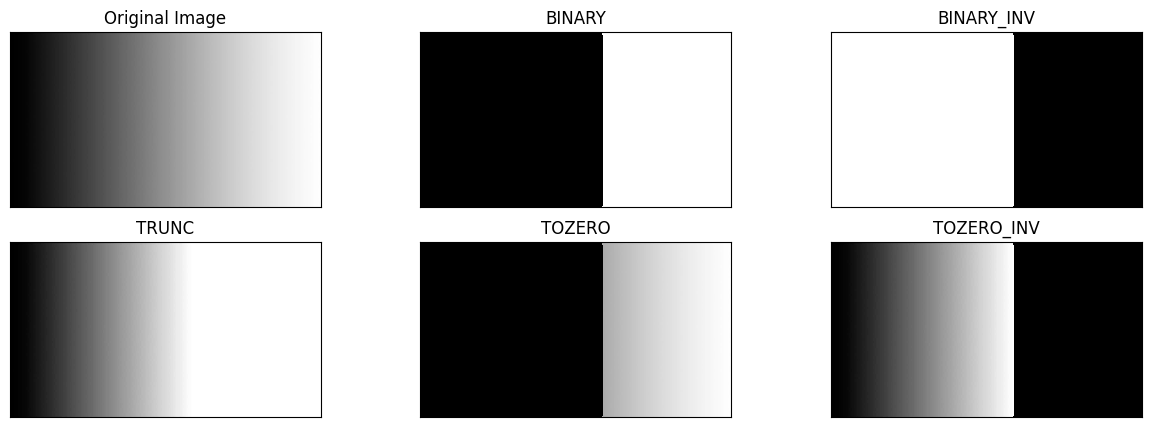

In [38]:
# Baca gambar
filename = '/content/drive/MyDrive/PCVK/Images/gradient.jpg'
img = cv2.imread(filename, 0)  # grayscale
thresh = 170

# 1. Binary Threshold
thresh1 = np.copy(img)
thresh1[img > thresh] = 255
thresh1[img <= thresh] = 0

# 2. Binary Inverted Threshold
thresh2 = 255 - thresh1

# 3. Truncate Threshold
thresh3 = np.copy(img)
thresh3[img > thresh] = thresh

# 4. Threshold ToZero
thresh4 = np.copy(img)
thresh4[img <= thresh] = 0

# 5. Threshold ToZero Inverted
thresh5 = np.copy(img)
thresh5[img > thresh] = 0

titles = ['Original Image', 'BINARY', 'BINARY_INV', 'TRUNC', 'TOZERO', 'TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

plt.figure(figsize=(15,5))
for i in range(len(images)):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i], 'gray', interpolation='nearest')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
plt.show()


# 3. Otsu’s Thresholding Manual (tanpa library)

Nilai Threshold Otsu: 100


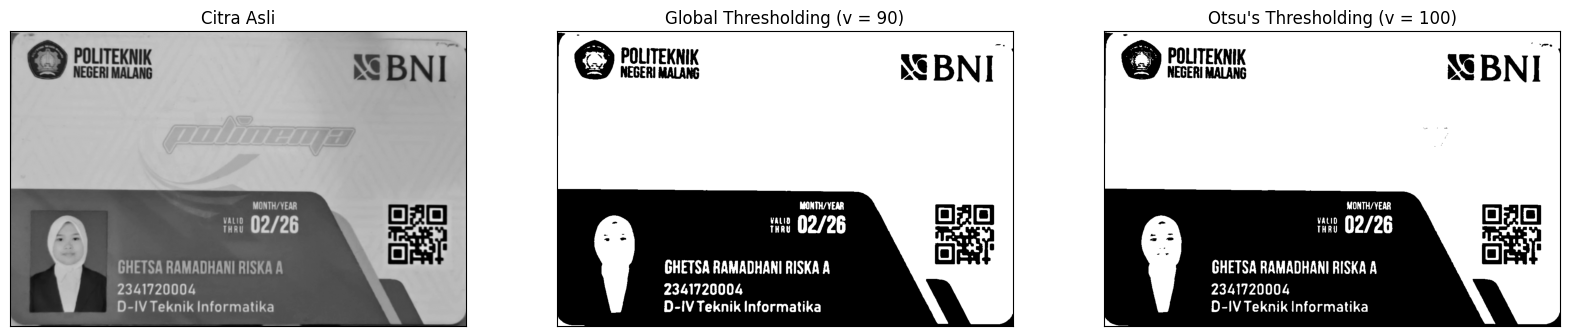

In [39]:
filename = '/content/drive/MyDrive/PCVK/KTM1b.jpg'
img = cv2.imread(filename, 0)
blur = cv2.GaussianBlur(img, (5,5), 0)

def otsu(gray):
    pixel_number = gray.shape[0] * gray.shape[1]
    mean_weight = 1.0 / pixel_number
    his, bins = np.histogram(gray, np.arange(0, 257))
    final_thresh = -1
    final_value = -1
    intensity_arr = np.arange(256)

    for t in bins[1:-1]:
        pcb = np.sum(his[:t])
        pcf = np.sum(his[t:])
        Wb = pcb * mean_weight
        Wf = pcf * mean_weight
        mub = np.sum(intensity_arr[:t]*his[:t]) / float(pcb) if pcb != 0 else 0
        muf = np.sum(intensity_arr[t:]*his[t:]) / float(pcf) if pcf != 0 else 0
        value = Wb * Wf * (mub - muf) ** 2
        if value > final_value:
            final_thresh = t
            final_value = value

    final_img = gray.copy()
    print("Nilai Threshold Otsu:", final_thresh)
    final_img[gray > final_thresh] = 255
    final_img[gray <= final_thresh] = 0
    return final_img, final_thresh

otsu_biner, otsu_thresh = otsu(img)
ret, th1 = cv2.threshold(blur, 90, 255, cv2.THRESH_BINARY)

titles = ['Citra Asli', 'Global Thresholding (v = 90)', f"Otsu's Thresholding (v = {otsu_thresh})"]
citra3 = [blur, th1, otsu_biner]

plt.figure(figsize=(20,10))
for i in range(len(citra3)):
    plt.subplot(1,3,i+1)
    plt.imshow(citra3[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
plt.show()


# 4. Histogram pada Foreground (Masking)

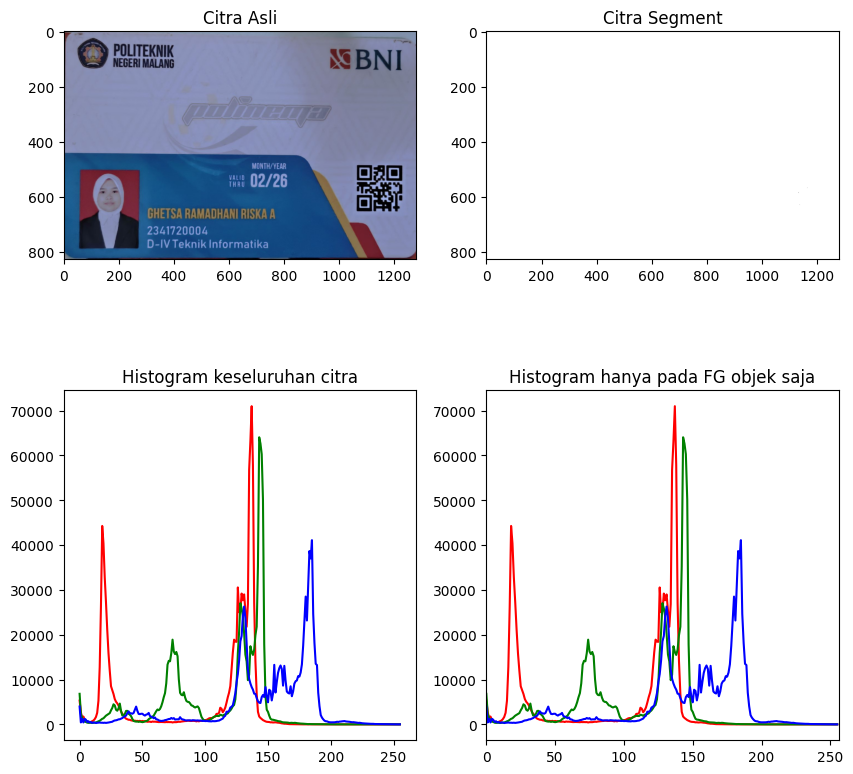

In [40]:
filename = '/content/drive/MyDrive/PCVK/KTM1b.jpg'
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Segmentasi dengan mask
ret3, mask = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1), plt.imshow(img), plt.title('Citra Asli')
plt.subplot(2,2,2), plt.imshow(mask, 'gray'), plt.title('Citra Segment')

color = ('r','g','b')
for i,col in enumerate(color):
    hist0 = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.subplot(2,2,3), plt.plot(hist0,color=col)
    plt.title('Histogram keseluruhan citra')

    hist1 = cv2.calcHist([img],[i],mask,[256],[0,256])
    plt.subplot(2,2,4), plt.plot(hist1,color=col)
    plt.title('Histogram hanya pada FG objek saja')
    plt.xlim([0,256])
plt.show()


# 5. Segmentasi Warna (K-Means, warna biru saja)

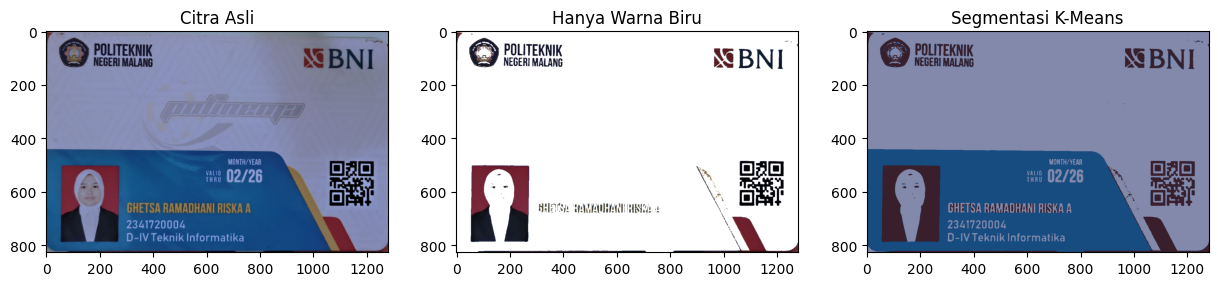

In [41]:
filename = '/content/drive/MyDrive/PCVK/KTM1b.jpg'
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# reshape image ke 2D
pixel_values = img.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# K-Means
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 150, 0.1)
k = 3
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
labels = labels.flatten()
segmented_image = centers[labels.flatten()].reshape(img.shape)

# tampilkan hanya cluster biru (misalnya cluster ke-1)
masked_image = np.copy(img)
masked_image0 = masked_image.reshape((-1, 3))
masked_image0[labels != 1] = [255, 255, 255]
masked_image0 = masked_image0.reshape(img.shape)

plt.figure(figsize=(15,10))
plt.subplot(1,3,1), plt.imshow(img), plt.title('Citra Asli')
plt.subplot(1,3,2), plt.imshow(masked_image0), plt.title('Hanya Warna Biru')
plt.subplot(1,3,3), plt.imshow(segmented_image), plt.title('Segmentasi K-Means')
plt.show()


(<Axes: >, <matplotlib.image.AxesImage at 0x7df0bdb22750>)

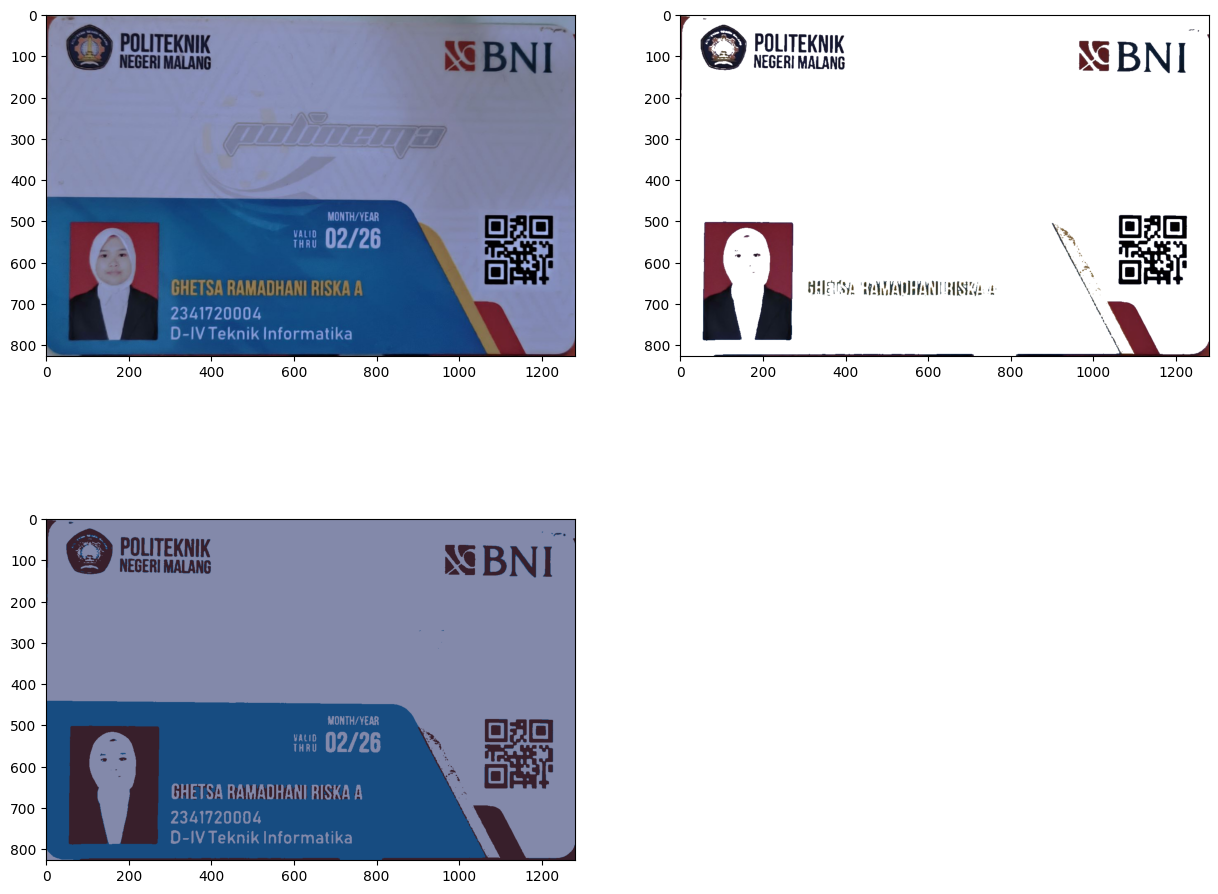

In [47]:
filename = '/content/drive/MyDrive/PCVK/KTM1b.jpg'
img = cv2.imread(filename)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
'''
kita akan menggunakan fungsi cv2.kmeans() yang meminta
array 2D sebagai masukan, sedangkan image aslinya adalah
array 3D
selanjutnya kita perlu melakukan flattening array image
masukan
'''
#reshape array ke bentuk 2D
pixel_values = img.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)

'''
syarat berhenti iterasi dr KMeans adalah jika centroid
sudah tidak terlalu banyak pergeseran posisi antara
interasi sekarang
dengan iterasi sebelumnya (konvergen). Karena jumlah data
yang besar, maka kita akan hentikan iterasi saat jumlah
iterasi = 100
atau epsilon(selisih antara posisi centroid skrg dgn
posisi centroid di iterasi sebelumnya) < 0.2
'''
criteria = (cv2.TERM_CRITERIA_EPS +
cv2.TERM_CRITERIA_MAX_ITER, 150, 0.1)
'''
jika diperhatikan pada image asli, terdapat 3 warna utama
(hijau, biru, dan putih/orange). untuk percobaan ini kita
akan gunakan
3 cluster untuk image ini
'''
k = 3
_, labels, (centers) = cv2.kmeans(pixel_values, k, None,
criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
#konversi titik centroid kedalam integer
centers = np.uint8(centers)
#flattening label array
labels = labels.flatten()
#konversi warna pixel asli kewarna dari tiap centroidnya
segmented_image = centers[labels.flatten()]
# reshape ke bentuk image asli
segmented_image = segmented_image.reshape(img.shape)
masked_image = np.copy(img)
masked_image0 = masked_image.reshape((-1, 3))
masked_image0[labels != 1] = [255, 255, 255]
masked_image0 = masked_image0.reshape(img.shape)
plt.figure(figsize = (15,12))
plt.subplot(2,2,1),plt.imshow(img)
plt.subplot(2,2,2),plt.imshow(masked_image0)
plt.subplot(2,2,3),plt.imshow(segmented_image)

# 6. OCR (Optical Character Recognition) dari Hasil Threshold

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-ind is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


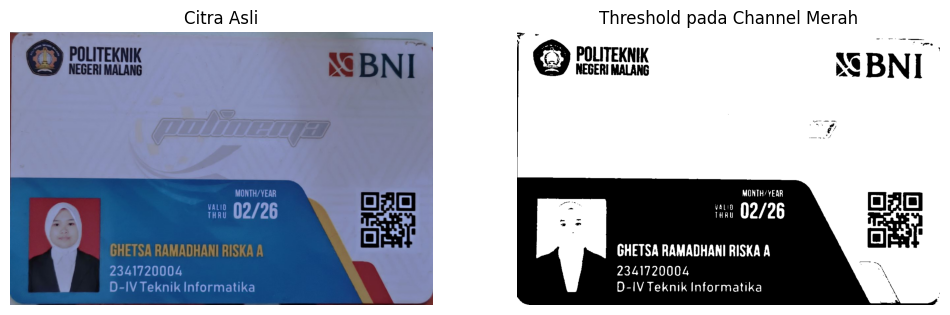

===== HASIL TEKS TERDETEKSI =====
i) reser ne

MONTH/ YEAR

IN 1721

NEEL UNL

2341720004
D-IV Teknik Informatika

 



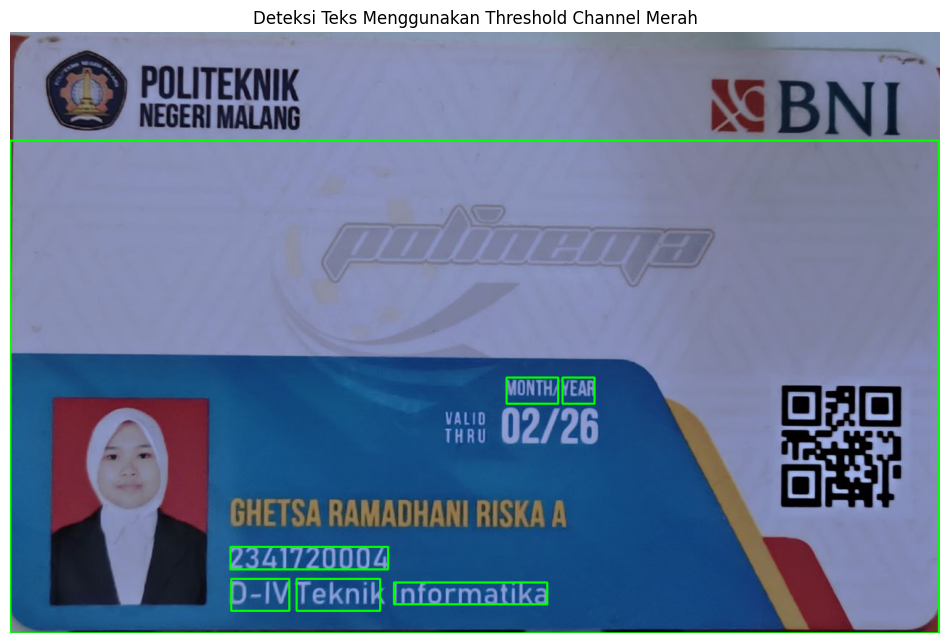

In [22]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr -y
!sudo apt-get install tesseract-ocr-ind -y

import cv2, pytesseract, numpy as np, matplotlib.pyplot as plt
from pytesseract import Output

# --- 1. Baca gambar ---
img = cv2.imread('/content/drive/MyDrive/PCVK/KTM1b.jpg')

# --- 2. Pisahkan channel warna ---
b, g, r = cv2.split(img)

# --- 3. Gunakan channel merah (huruf kuning paling kontras di sini) ---
red_enhanced = cv2.convertScaleAbs(r, alpha=1.8, beta=-30)

# --- 4. Lakukan thresholding di channel merah ---
_, thresh_red = cv2.threshold(red_enhanced, 150, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Citra Asli")
plt.axis("off")
plt.subplot(1,2,2), plt.imshow(thresh_red, cmap="gray")
plt.title("Threshold pada Channel Merah")
plt.axis("off")
plt.show()

# --- 5. OCR pada hasil threshold ---
text_data = pytesseract.image_to_data(thresh_red, output_type='data.frame', lang="eng+ind")
text_string = pytesseract.image_to_string(thresh_red, lang="eng+ind")

print("===== HASIL TEKS TERDETEKSI =====")
print(text_string)

# --- 6. Tambahkan bounding box teks terdeteksi ---
img_box = img.copy()
for i in range(len(text_data)):
    if text_data.conf[i] > 60:
        (x, y, w, h) = (text_data.left[i], text_data.top[i],
                        text_data.width[i], text_data.height[i])
        cv2.rectangle(img_box, (x, y), (x+w, y+h), (0,255,0), 2)

plt.figure(figsize=(12,10))
plt.imshow(cv2.cvtColor(img_box, cv2.COLOR_BGR2RGB))
plt.title("Deteksi Teks Menggunakan Threshold Channel Merah")
plt.axis("off")
plt.show()


# 7. Tugas Akhir

In [24]:
# Gunakan hasil threshold dari tahap sebelumnya
thresholded_img = thresh_red  # misal hasil binary threshold

text3 = pytesseract.image_to_string(thresholded_img, lang="eng+ind")
print("===== TEKS DARI HASIL GLOBAL THRESHOLDING =====")
print(text3)


===== TEKS DARI HASIL GLOBAL THRESHOLDING =====
i) reser ne

MONTH/ YEAR

IN 1721

NEEL UNL

2341720004
D-IV Teknik Informatika

 



# D2. TUGAS KELOMPOK
Pisahkan obyek wajah dengan background pada semua citra pada kasus CM. bebas menggunakan metode-metode segmentasi